# 🚀 Commodity Price Forecasting — Transformer Models Demo v2

This notebook demonstrates:
1. **Training** all 5 lightweight Transformers: PatchTST, DLinear, Autoformer, iTransformer, TSTransformer
2. **Fine-tuning** each model with `TransformerFineTuner`
3. **Visualization** — Predictions vs Ground Truth for every model
4. **Model Comparison** table & charts

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('.'))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from loguru import logger

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

PyTorch: 2.4.1+cpu
CUDA: False
Device: cpu


## 1. Load & Prepare Data

In [2]:
from src.ingestion.loader import CommodityLoader
from src.preprocessing.cleaner import DataCleaner
from src.features.generator import FeatureGenerator

# Load data
loader = CommodityLoader('configs/commodities.yaml')
commodity_id = list(loader.commodities.keys())[9] if loader.commodities else 'steel_rebar'
print(f"Using: {commodity_id}")

df = loader.load_commodity(commodity_id)
df = DataCleaner().clean(df)
fg = FeatureGenerator(lag_days=[1,2,3,5,7,14,21,30], rolling_windows=[7,14,30,60])
df = fg.generate(df)

# Only numeric columns as features
exclude_cols = {'date', 'close', 'open', 'high', 'low', 'volume', 'commodity', 'commodity_id'}
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
df_clean = df.dropna(subset=feature_cols + ['close']).copy()

# Split 80/20
SEQ_LEN = 60
split = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split]
test_df = df_clean.iloc[split:]
X_train, y_train = train_df[feature_cols], train_df['close']
X_test, y_test = test_df[feature_cols], test_df['close']

# Aligned ground truth: predict() returns (len - seq_len + 1) values
# so we align y_test to the LAST (len - seq_len + 1) values
n_preds = len(X_test) - SEQ_LEN + 1
y_test_aligned = y_test.iloc[SEQ_LEN - 1:].values  # shape = (n_preds,)

print(f"Features: {len(feature_cols)}, Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Aligned predictions will have {n_preds} values")

2026-02-11 09:09:38.610 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1489 records for rubber
2026-02-11 09:09:38.626 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)


Using: rubber
Features: 55, Train: 1248, Test: 312
Aligned predictions will have 253 values


## 2. Train All Lightweight Models

In [3]:
from src.models.transformer_models import (
    PatchTSTForecaster, DLinearForecaster, AutoformerForecaster,
    iTransformerForecaster, TSTransformerForecaster
)
from src.evaluation.metrics import calculate_metrics

# Define models
model_configs = {
    'PatchTST': PatchTSTForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'DLinear': DLinearForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'Autoformer': AutoformerForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'iTransformer': iTransformerForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'TSTransformer': TSTransformerForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
}

results = {}      # {name: metrics_dict}
predictions = {}  # {name: np.array of predictions}
trained_models = {}  # {name: fitted model}

for name, model in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    try:
        model.fit(y_train, X_train, X_val=X_test, y_val=y_test)
        preds = model.predict(X=X_test)
        
        # Align: preds has shape (len(X_test) - seq_len + 1,)
        min_len = min(len(preds), len(y_test_aligned))
        preds_aligned = preds[:min_len]
        gt_aligned = y_test_aligned[:min_len]
        
        metrics = calculate_metrics(gt_aligned, preds_aligned, y_train.values)
        results[name] = metrics
        predictions[name] = preds_aligned
        trained_models[name] = model
        print(f"  ✅ MAE={metrics.get('mae',0):.4f}, RMSE={metrics.get('rmse',0):.4f}")
    except Exception as e:
        print(f"  ❌ ERROR: {e}")
        results[name] = {'error': str(e)}

print(f"\n{'='*60}")
print(f"Successfully trained: {list(predictions.keys())}")


Training PatchTST...


2026-02-11 09:09:44.187 | INFO     | src.models.transformer_models:fit:373 - Training PatchTST: 126,913 params, device=cpu, epochs=50
2026-02-11 09:09:44.838 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=55335.726879, val_loss=81006.403320
2026-02-11 09:09:54.701 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=666.665639, val_loss=871.233824
2026-02-11 09:10:10.732 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=541.736441, val_loss=1436.142767
2026-02-11 09:10:25.289 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=466.956330, val_loss=826.109164
2026-02-11 09:10:39.721 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=434.992633, val_loss=919.677785
2026-02-11 09:10:54.012 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=438.592230, val_loss=890.146719
2026-02-11 09:10:54.019 | INFO     | src.models.tran

  ✅ MAE=16.5879, RMSE=20.5131

Training DLinear...


2026-02-11 09:10:55.523 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=9223.357964, val_loss=378.916534
2026-02-11 09:10:57.172 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=3069.824195, val_loss=9453.104858
2026-02-11 09:10:59.146 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=2428.648726, val_loss=725.436115
2026-02-11 09:11:01.055 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=291.241281, val_loss=525.128132
2026-02-11 09:11:02.954 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=116.904034, val_loss=116.053359
2026-02-11 09:11:04.872 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=37.904750, val_loss=101.033352
2026-02-11 09:11:04.877 | INFO     | src.models.transformer_models:fit:442 - DLinear training complete. Best val_loss=89.211622
2026-02-11 09:11:05.014 | INFO     | src.models.transformer_

  ✅ MAE=6.3289, RMSE=8.3294

Training Autoformer...


2026-02-11 09:11:09.704 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=61965.512774, val_loss=102127.784180
2026-02-11 09:11:49.485 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=2874.506410, val_loss=3425.229401
2026-02-11 09:12:31.340 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=1033.632064, val_loss=666.778072
2026-02-11 09:13:13.191 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=776.925168, val_loss=1088.458563
2026-02-11 09:13:55.447 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=818.330832, val_loss=530.581970
2026-02-11 09:14:38.477 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=713.944682, val_loss=681.575886
2026-02-11 09:14:38.483 | INFO     | src.models.transformer_models:fit:442 - Autoformer training complete. Best val_loss=276.073938
2026-02-11 09:14:41.384 | INFO     | src.models.tr

  ✅ MAE=11.8206, RMSE=16.1550

Training iTransformer...


2026-02-11 09:14:44.348 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=26720.455065, val_loss=6105.324585
2026-02-11 09:15:10.316 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=855.902098, val_loss=1693.770920
2026-02-11 09:15:40.453 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=1786.382197, val_loss=6388.462509
2026-02-11 09:16:09.140 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=1342.947417, val_loss=6278.944153
2026-02-11 09:16:37.424 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=1219.618243, val_loss=7366.140289
2026-02-11 09:17:08.027 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=1121.331388, val_loss=7271.497681
2026-02-11 09:17:08.035 | INFO     | src.models.transformer_models:fit:442 - iTransformer training complete. Best val_loss=215.691164
2026-02-11 09:17:09.641 | INFO     | src.mode

  ✅ MAE=12.2636, RMSE=14.4364

Training TSTransformer...


2026-02-11 09:17:12.386 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=61297.998522, val_loss=100185.502930
2026-02-11 09:17:37.481 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=2980.829679, val_loss=6016.961731
2026-02-11 09:18:05.717 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=675.909284, val_loss=615.954987
2026-02-11 09:18:32.810 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=566.347410, val_loss=354.110549
2026-02-11 09:19:00.018 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=517.937324, val_loss=301.480572
2026-02-11 09:19:26.452 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=499.531328, val_loss=188.148158
2026-02-11 09:19:26.458 | INFO     | src.models.transformer_models:fit:442 - TSTransformer training complete. Best val_loss=145.324069


  ✅ MAE=7.5131, RMSE=11.1023

Successfully trained: ['PatchTST', 'DLinear', 'Autoformer', 'iTransformer', 'TSTransformer']


## 3. Visualize Predictions vs Ground Truth (Each Model)

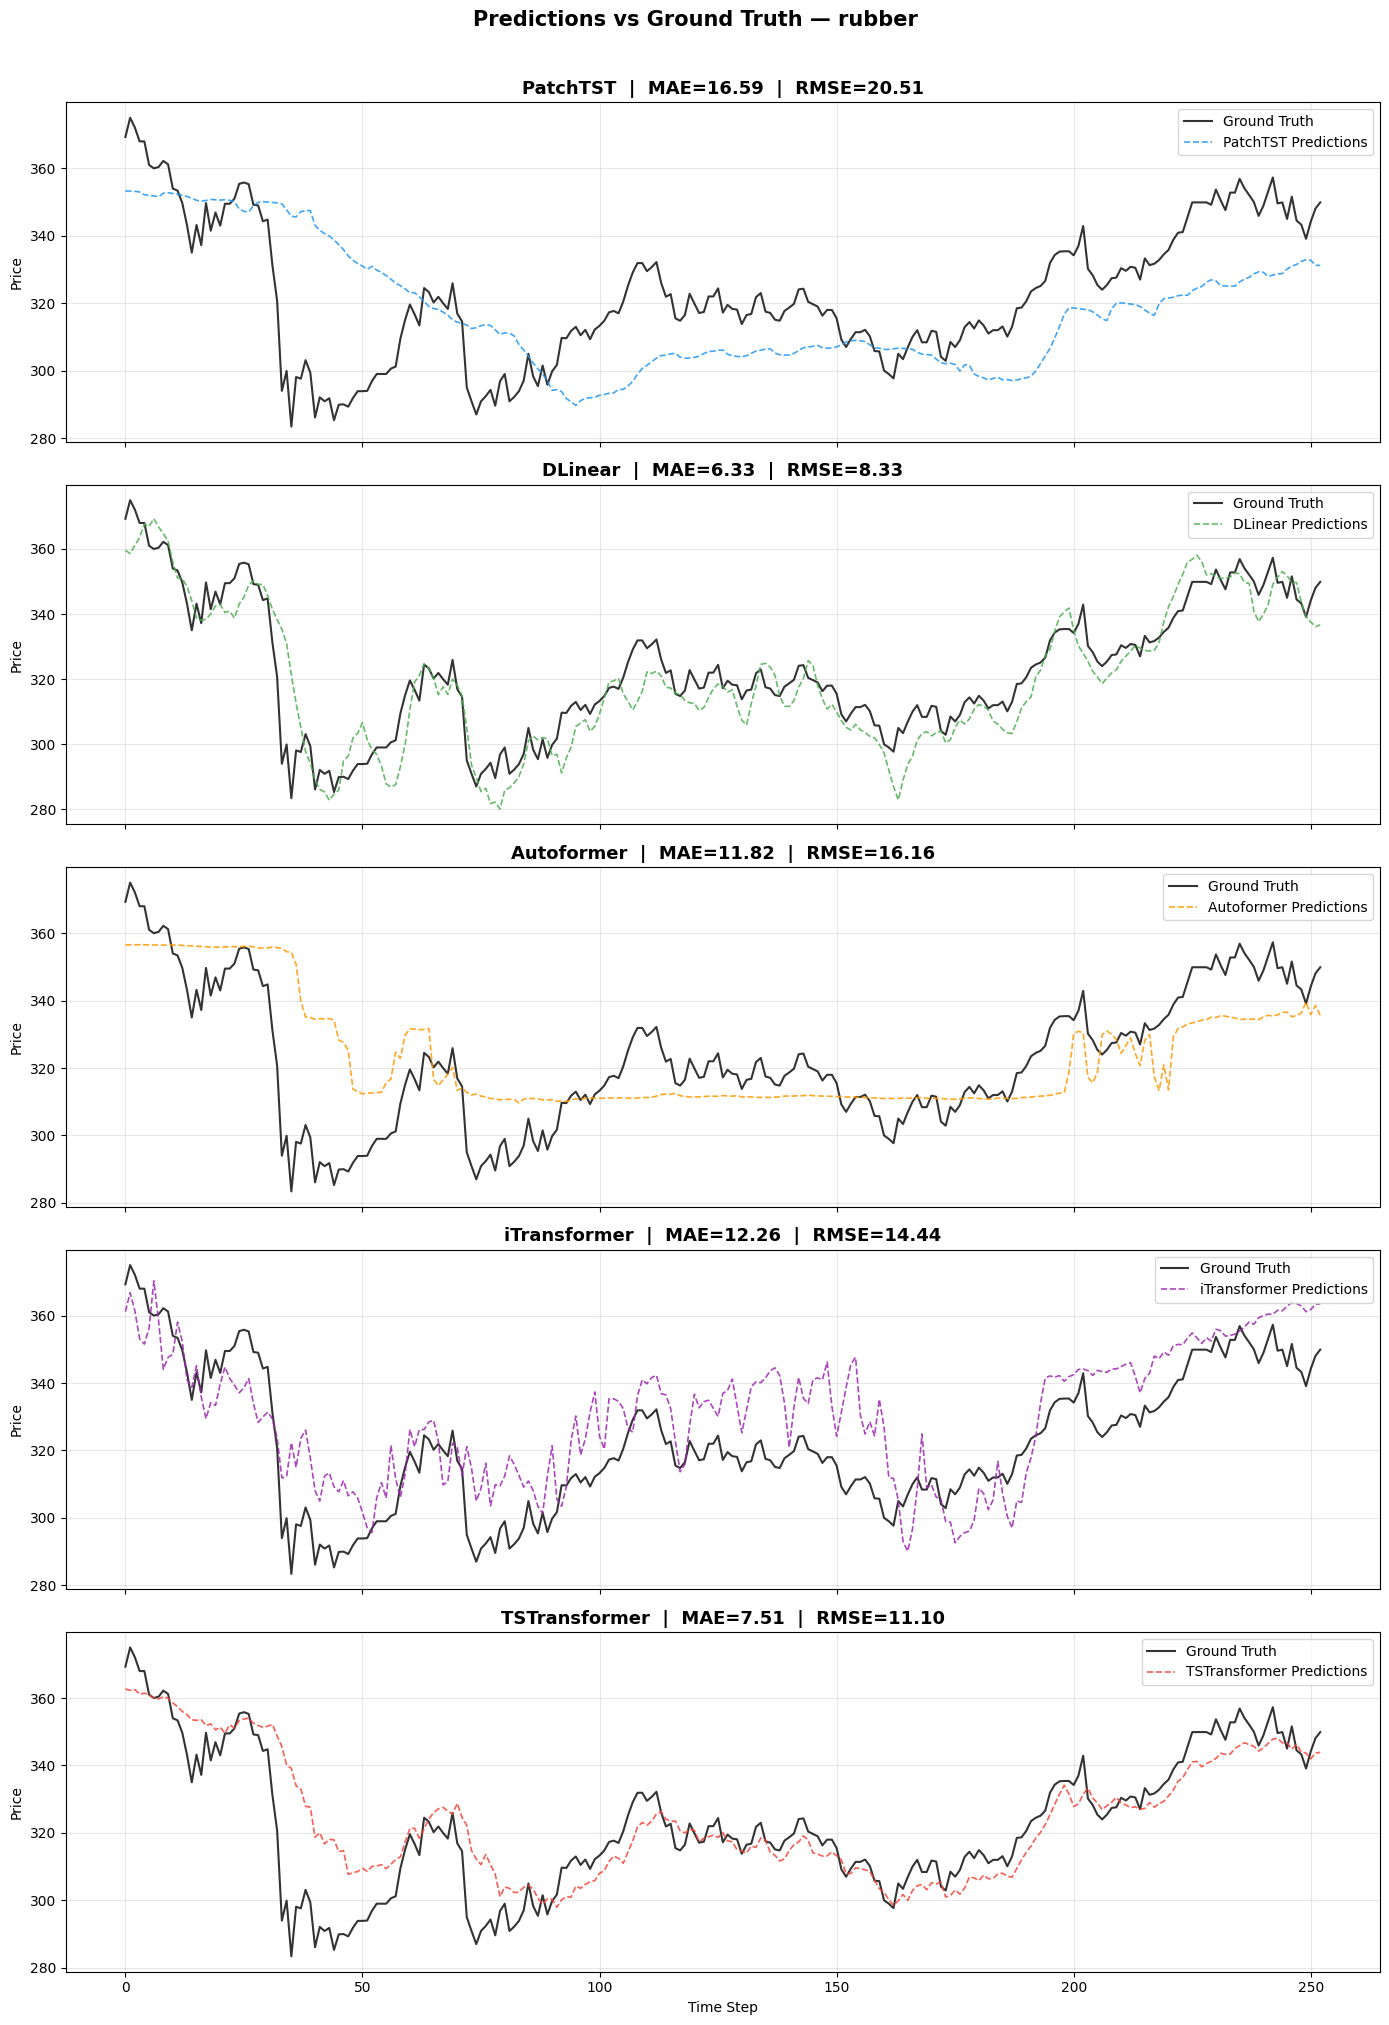

In [4]:
# Individual plots for each model
successful_models = [n for n in predictions.keys()]
n_models = len(successful_models)

if n_models > 0:
    fig, axes = plt.subplots(n_models, 1, figsize=(14, 4 * n_models), sharex=True)
    if n_models == 1:
        axes = [axes]
    
    colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#F44336']
    
    for idx, name in enumerate(successful_models):
        ax = axes[idx]
        preds = predictions[name]
        gt = y_test_aligned[:len(preds)]
        
        ax.plot(gt, label='Ground Truth', color='black', linewidth=1.5, alpha=0.8)
        ax.plot(preds, label=f'{name} Predictions', color=colors[idx % len(colors)], 
                linewidth=1.2, alpha=0.85, linestyle='--')
        
        mae = results[name].get('mae', 0)
        rmse = results[name].get('rmse', 0)
        ax.set_title(f'{name}  |  MAE={mae:.2f}  |  RMSE={rmse:.2f}', fontsize=13, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Price')
    
    axes[-1].set_xlabel('Time Step')
    plt.suptitle(f'Predictions vs Ground Truth — {commodity_id}', fontsize=15, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No models trained successfully.")

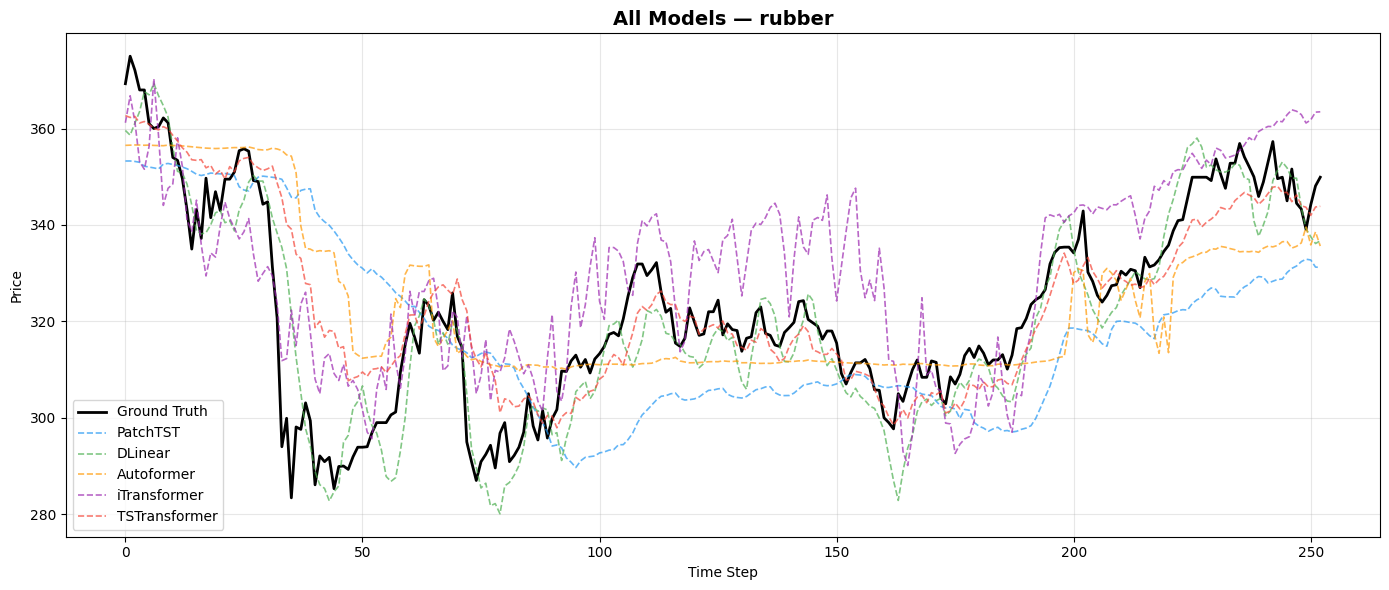

In [5]:
# Overlay plot: all models on one chart
if n_models > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    gt = y_test_aligned[:min(len(p) for p in predictions.values())]
    ax.plot(gt, label='Ground Truth', color='black', linewidth=2)
    
    for idx, (name, preds) in enumerate(predictions.items()):
        ax.plot(preds[:len(gt)], label=name, color=colors[idx % len(colors)], 
                linewidth=1.2, alpha=0.7, linestyle='--')
    
    ax.set_title(f'All Models — {commodity_id}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price')
    plt.tight_layout()
    plt.show()

## 4. Fine-tuning Each Model with TransformerFineTuner

In [6]:
from src.training.finetuner import TransformerFineTuner

ft_results = {}       # {name: finetune metrics}
ft_predictions = {}   # {name: predictions after fine-tuning}

for name, model in trained_models.items():
    print(f"\n{'='*60}")
    print(f"Fine-tuning {name}...")
    try:
        finetuner = TransformerFineTuner(
            model=model,
            seq_len=SEQ_LEN,
            lr=5e-5,          # Lower LR for fine-tuning
            epochs=50,
            patience=15,
            warmup_steps=50,
            grad_accum_steps=2,
            use_amp=torch.cuda.is_available(),
        )
        
        train_loader, val_loader = finetuner.prepare_data(
            df_clean, feature_cols, target_col='close', train_ratio=0.8
        )
        
        ft_metric = finetuner.finetune(train_loader, val_loader)
        ft_results[name] = ft_metric
        
        # Re-predict after fine-tuning
        preds_ft = model.predict(X=X_test)
        min_len = min(len(preds_ft), len(y_test_aligned))
        ft_predictions[name] = preds_ft[:min_len]
        
        eval_metrics = finetuner.evaluate(val_loader)
        print(f"  ✅ Fine-tune val_loss={ft_metric.get('best_val_loss',0):.6f}")
        print(f"     Eval: MSE={eval_metrics.get('mse',0):.4f}, MAE={eval_metrics.get('mae',0):.4f}")
    except Exception as e:
        print(f"  ❌ Fine-tuning failed: {e}")

2026-02-11 09:20:54.265 | INFO     | src.features.sequence_dataset:create_sequence_dataloaders:114 - Sequence dataset: train=1248, val=312, seq_len=60, horizon=1
2026-02-11 09:20:54.266 | INFO     | src.training.finetuner:prepare_data:121 - Fine-tuner data: 1188 train, 252 val samples
d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=self.use_amp)
2026-02-11 09:20:54.269 | INFO     | src.training.finetuner:finetune:187 - Fine-tuning PatchTST: params=126,913, device=cpu, epochs=50, AMP=False, grad_accum=2



Fine-tuning PatchTST...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-11 09:20:54.737 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=550.139460, val=418.879077, lr=1.80e-05
2026-02-11 09:20:57.146 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=477.306839, val=741.955469, lr=4.97e-05
2026-02-11 09:21:00.822 | INFO     | src.training.finetuner:finetune:243 -   Epoch 10/50: train=487.885425, val=758.669403, lr=4.73e-05
2026-02-11 09:21:05.005 | INFO     | src.training.finetuner:finetune:243 -   Epoch 15/50: train=468.189946, val=675.710371, lr=4.26e-05
20

  ✅ Fine-tune val_loss=418.879077
     Eval: MSE=422.3174, MAE=14.3266

Fine-tuning DLinear...


2026-02-11 09:21:06.665 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=65.418067, val=129.434869, lr=4.97e-05
2026-02-11 09:21:07.196 | INFO     | src.training.finetuner:finetune:243 -   Epoch 10/50: train=42.613471, val=104.733670, lr=4.73e-05
2026-02-11 09:21:07.747 | INFO     | src.training.finetuner:finetune:243 -   Epoch 15/50: train=43.362430, val=115.406025, lr=4.26e-05
2026-02-11 09:21:08.263 | INFO     | src.training.finetuner:finetune:243 -   Epoch 20/50: train=80.180344, val=163.874682, lr=3.60e-05
2026-02-11 09:21:08.787 | INFO     | src.training.finetuner:finetune:243 -   Epoch 25/50: train=50.387787, val=143.859551, lr=2.84e-05
2026-02-11 09:21:09.342 | INFO     | src.training.finetuner:finetune:243 -   Epoch 30/50: train=44.994806, val=87.550178, lr=2.03e-05
2026-02-11 09:21:09.782 | INFO     | src.training.finetuner:finetune:243 -   Epoch 35/50: train=44.535951, val=133.159293, lr=1.28e-05
2026-02-11 09:21:10.126 | INFO     | src.training.finetun

  ✅ Fine-tune val_loss=87.550178
     Eval: MSE=88.1587, MAE=6.5640

Fine-tuning Autoformer...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-11 09:21:12.384 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=928.396305, val=295.553204, lr=1.80e-05
2026-02-11 09:21:28.243 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=892.667517, val=682.878808, lr=4.97e-05
2026-02-11 09:21:48.820 | INFO     | src.training.finetuner:finetune:243 -   Epoch 10/50: train=875.979916, val=646.218143, lr=4.73e-05
2026-02-11 09:22:08.070 | INFO     | src.training.finetuner:finetune:243 -   Epoch 15/50: train=901.154011, val=551.618385, lr=4.26e-05
2026-02-11 09:22:12.931 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 16
2026-02-11 09:22:12.937 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=295.553204 afte

  ✅ Fine-tune val_loss=295.553204
     Eval: MSE=298.6118, MAE=11.7924

Fine-tuning iTransformer...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-11 09:22:18.614 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=1356.056269, val=540.725379, lr=1.80e-05
2026-02-11 09:22:28.661 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=688.024235, val=2273.116989, lr=4.97e-05
2026-02-11 09:22:42.655 | INFO     | src.training.finetuner:finetune:243 -   Epoch 10/50: train=651.629811, val=2982.333801, lr=4.73e-05
2026-02-11 09:22:57.596 | INFO     | src.training.finetuner:finetune:243 -   Epoch 15/50: train=594.464994, val=2825.770409, lr=4.26e-05
2026-02-11 09:23:00.679 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 16
2026-02-11 09:23:00.683 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=540.725379 

  ✅ Fine-tune val_loss=540.725379
     Eval: MSE=542.8239, MAE=20.4405

Fine-tuning TSTransformer...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-11 09:23:05.053 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=539.251117, val=160.694312, lr=1.80e-05
2026-02-11 09:23:18.062 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=526.301909, val=178.071736, lr=4.97e-05
2026-02-11 09:23:30.570 | INFO     | src.training.finetuner:finetune:243 -   Epoch 10/50: train=520.103288, val=220.137177, lr=4.73e-05
2026-02-11 09:23:43.369 | INFO     | src.training.finetuner:finetune:243 -   Epoch 15/50: train=550.734754, val=174.947994, lr=4.26e-05
2026-02-11 09:23:57.912 | INFO     | src.training.finetuner:finetune:243 -   Epoch 20/50: train=534.243303, val=183.304000, lr=3.60e-05
2026-02-11 09:24:10.700 | INFO     | src.training.finetuner:finetune:243 -   Epoch 25/50: trai

  ✅ Fine-tune val_loss=144.023993
     Eval: MSE=145.7095, MAE=7.9124


## 5. Before vs After Fine-tuning Comparison

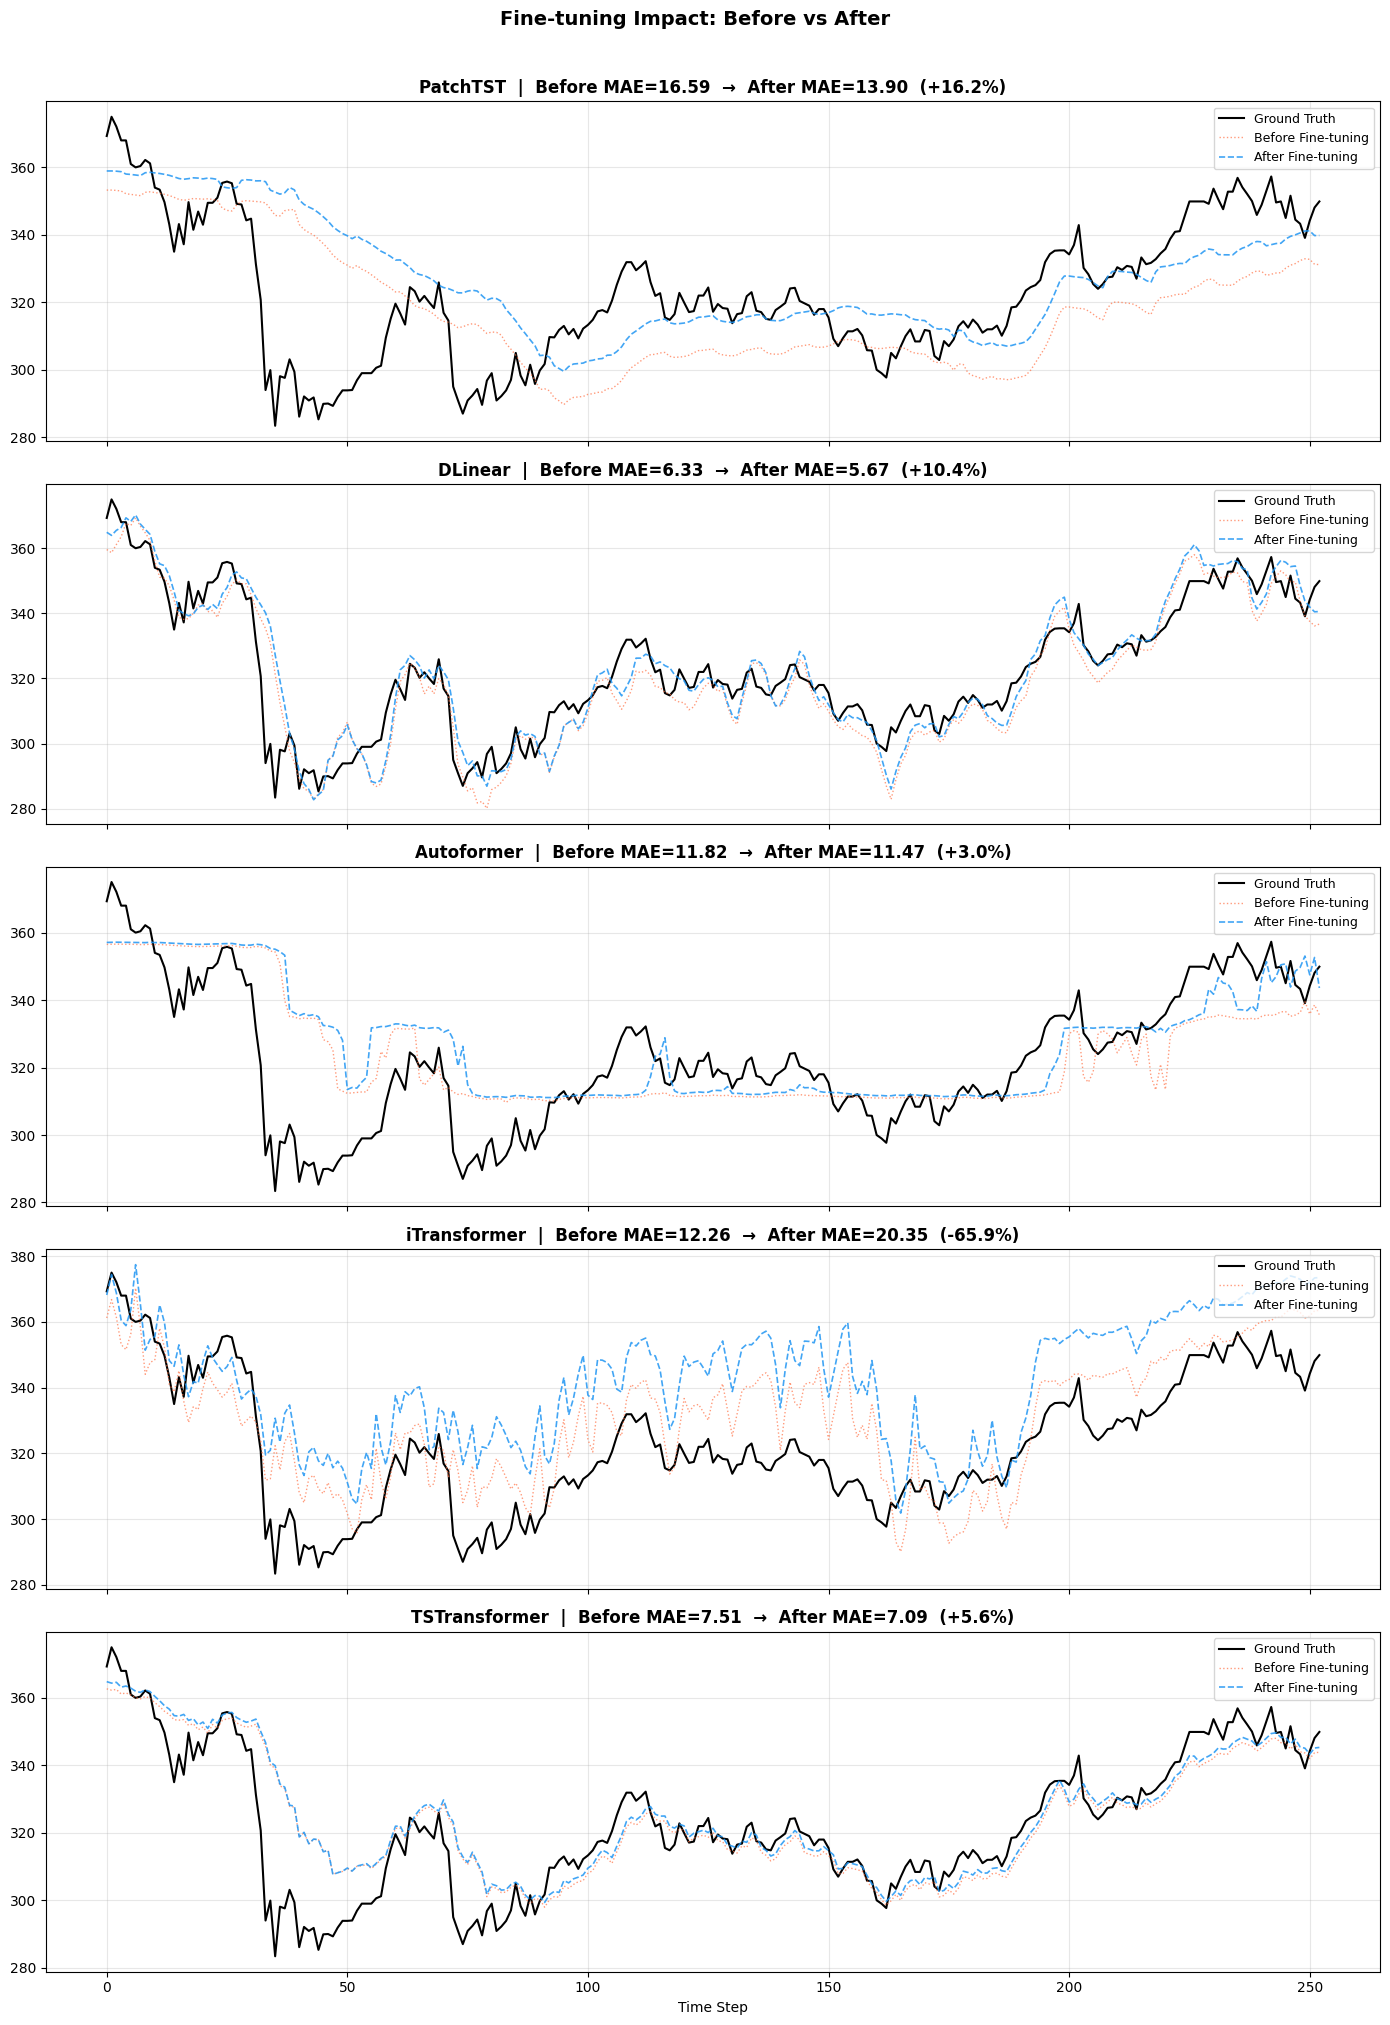

In [7]:
# Compare Before vs After fine-tuning for each model
models_with_ft = [n for n in ft_predictions.keys() if n in predictions]

if models_with_ft:
    fig, axes = plt.subplots(len(models_with_ft), 1, figsize=(14, 4 * len(models_with_ft)), sharex=True)
    if len(models_with_ft) == 1:
        axes = [axes]
    
    for idx, name in enumerate(models_with_ft):
        ax = axes[idx]
        preds_before = predictions[name]
        preds_after = ft_predictions[name]
        min_len = min(len(preds_before), len(preds_after), len(y_test_aligned))
        gt = y_test_aligned[:min_len]
        
        ax.plot(gt, label='Ground Truth', color='black', linewidth=1.5)
        ax.plot(preds_before[:min_len], label='Before Fine-tuning', 
                color='#FF7043', linewidth=1, alpha=0.7, linestyle=':')
        ax.plot(preds_after[:min_len], label='After Fine-tuning', 
                color='#2196F3', linewidth=1.2, alpha=0.85, linestyle='--')
        
        mae_before = np.mean(np.abs(gt - preds_before[:min_len]))
        mae_after = np.mean(np.abs(gt - preds_after[:min_len]))
        improvement = ((mae_before - mae_after) / mae_before * 100) if mae_before > 0 else 0
        
        ax.set_title(f'{name}  |  Before MAE={mae_before:.2f}  →  After MAE={mae_after:.2f}  '
                     f'({improvement:+.1f}%)', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time Step')
    plt.suptitle('Fine-tuning Impact: Before vs After', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No fine-tuned models to compare.")

## 6. Model Comparison Table


📊 Model Comparison (sorted by MAE):
        Model     MAE    RMSE   MASE  sMAPE  MAE (Fine-tuned)
      DLinear  6.3289  8.3294 2.1469 1.9929            5.6699
TSTransformer  7.5131 11.1023 2.5486 2.3593            7.0896
   Autoformer 11.8206 16.1550 4.0099 3.6698           11.4662
 iTransformer 12.2636 14.4364 4.1602 3.7879           20.3500
     PatchTST 16.5879 20.5131 5.6271 5.1959           13.9024


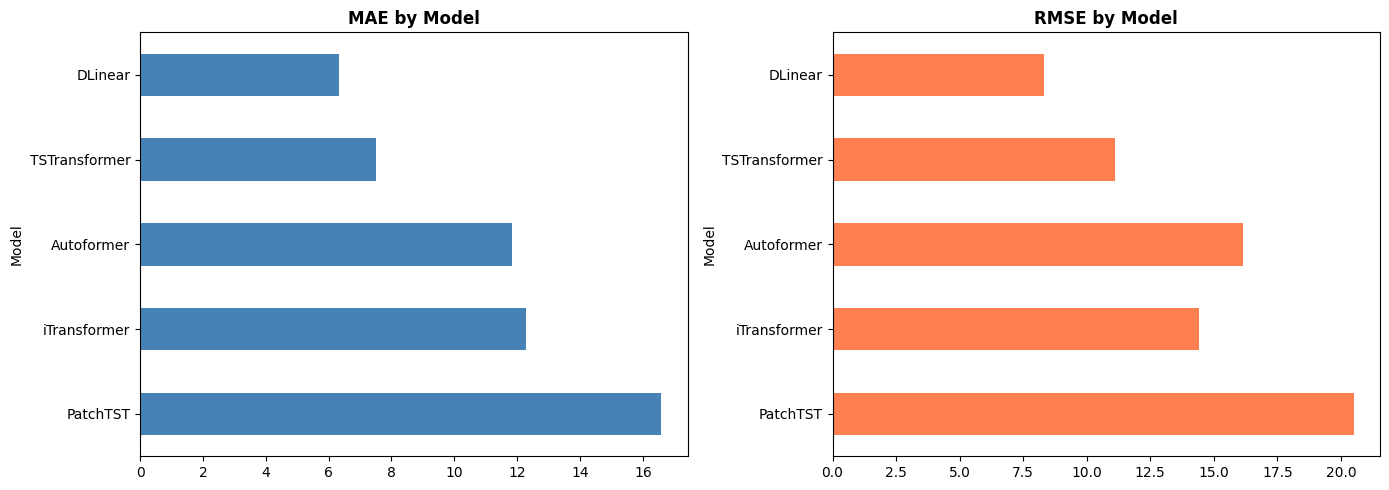

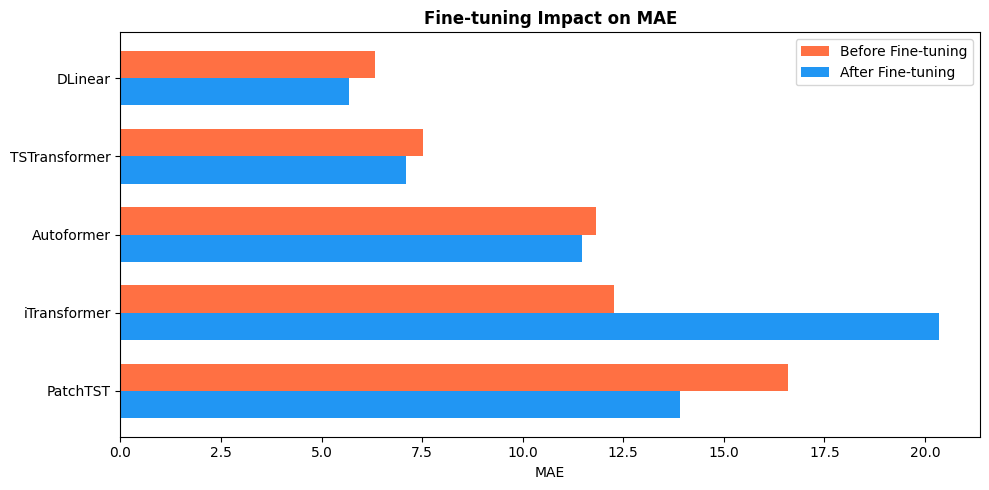

In [8]:
# Build comparison DataFrame
comparison = []
for name, metrics in results.items():
    if 'error' not in metrics:
        row = {
            'Model': name,
            'MAE': metrics.get('mae', None),
            'RMSE': metrics.get('rmse', None),
            'MASE': metrics.get('mase', None),
            'sMAPE': metrics.get('smape', None),
        }
        # Add fine-tuned MAE if available
        if name in ft_predictions:
            preds_ft = ft_predictions[name]
            gt = y_test_aligned[:len(preds_ft)]
            row['MAE (Fine-tuned)'] = np.mean(np.abs(gt - preds_ft))
        comparison.append(row)

if comparison:
    comp_df = pd.DataFrame(comparison)
    comp_df = comp_df.sort_values('MAE')
    print("\n📊 Model Comparison (sorted by MAE):")
    print(comp_df.to_string(index=False, float_format='%.4f'))
    
    # Bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    comp_df.plot.barh(x='Model', y='MAE', ax=axes[0], color='steelblue', legend=False)
    axes[0].set_title('MAE by Model', fontweight='bold')
    axes[0].invert_yaxis()
    
    comp_df.plot.barh(x='Model', y='RMSE', ax=axes[1], color='coral', legend=False)
    axes[1].set_title('RMSE by Model', fontweight='bold')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Before vs After fine-tuning comparison
    if 'MAE (Fine-tuned)' in comp_df.columns:
        fig, ax = plt.subplots(figsize=(10, 5))
        x = range(len(comp_df))
        w = 0.35
        ax.barh([i - w/2 for i in x], comp_df['MAE'], w, label='Before Fine-tuning', color='#FF7043')
        ax.barh([i + w/2 for i in x], comp_df['MAE (Fine-tuned)'].fillna(comp_df['MAE']), w, 
                label='After Fine-tuning', color='#2196F3')
        ax.set_yticks(x)
        ax.set_yticklabels(comp_df['Model'])
        ax.set_xlabel('MAE')
        ax.set_title('Fine-tuning Impact on MAE', fontweight='bold')
        ax.legend()
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()
else:
    print("No successful model results to compare.")

## 7. Prediction Error Distribution

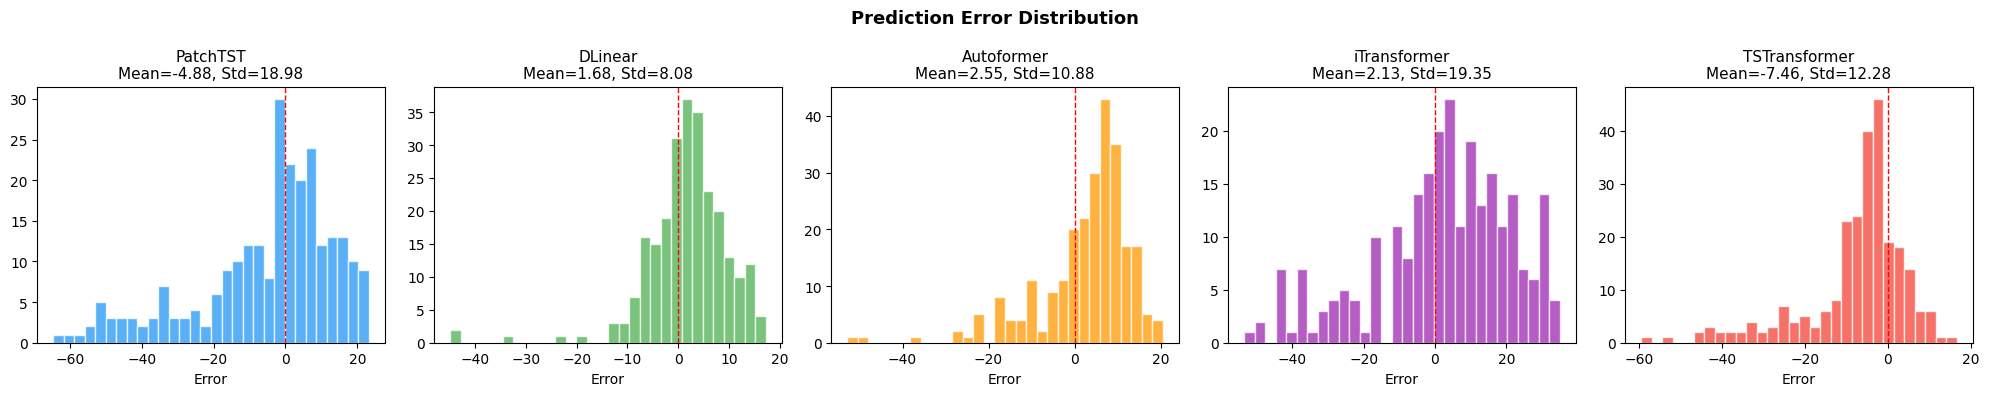

In [13]:
# Error distribution for each model
if predictions:
    fig, axes = plt.subplots(1, len(predictions), figsize=(4 * len(predictions), 4))
    if len(predictions) == 1:
        axes = [axes]
    
    for idx, (name, preds) in enumerate(predictions.items()):
        gt = y_test_aligned[:len(preds)]
        errors = gt - preds
        
        ax = axes[idx]
        ax.hist(errors, bins=30, color=colors[idx % len(colors)], alpha=0.75, edgecolor='white')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
        ax.set_title(f'{name}\nMean={np.mean(errors):.2f}, Std={np.std(errors):.2f}', fontsize=11)
        ax.set_xlabel('Error')
    
    plt.suptitle('Prediction Error Distribution', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. Future Price Prediction (Autoregressive)

Since our models are trained to predict t+1, we predict future prices step-by-step:

1. Predict t+1
2. Append prediction to history
3. Re-calculate features (lags, rolling stats, etc.)
4. Repeat for H steps

In [14]:
def predict_future_autoregressive(model, start_df, horizon, feature_generator):
    """
    Predict future values autoregressively.
    
    Args:
        model: Trained model (must have predict method)
        start_df: DataFrame containing the initial history (must include all necessary lags/windows)
        horizon: Number of steps to predict
        feature_generator: FeatureGenerator instance to update features
        
    Returns:
        DataFrame with future predictions
    """
    current_df = start_df.copy()
    future_preds = []
    
    # Get static columns to propagate (e.g., commodity_id)
    static_cols = ['commodity_id', 'commodity']
    if not current_df.empty:
        last_row = current_df.iloc[-1]
        static_data = {c: last_row[c] for c in static_cols if c in current_df.columns}
    else:
        static_data = {}
    
    if not current_df.empty:
        last_date = pd.to_datetime(current_df['date'].iloc[-1])
    else:
        raise ValueError("start_df is empty!")

    # Generate business days for future
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=horizon)
    
    print(f"Predicting {horizon} steps into the future...")
    
    target_col = feature_generator.target_column
    
    for i, date in enumerate(future_dates):
        # 1. Create a new row for the next date
        row_data = {'date': [date]}
        # Propagate static data
        for k, v in static_data.items():
            row_data[k] = [v]
            
        new_row = pd.DataFrame(row_data)
        
        # 2. Append to current dataframe
        current_df = pd.concat([current_df, new_row], ignore_index=True)
        
        # 3. Regenerate features
        # Note: This is computationally expensive but ensures correctness for all rolling/lag features
        try:
             current_df_feat = feature_generator.generate(current_df)
        except Exception as e:
             # Fallback if generation fails (e.g. strict checks)
             print(f"Feature generation warning at step {i}: {e}")
             current_df_feat = current_df # risky but better than crash?
        
        # 4. Prepare input for model
        if hasattr(model, 'feature_names_'):
             feats = model.feature_names_
        else:
             # Fallback: check columns in current_df_feat
             # If generation failed, this might be raw columns.
             # but usually models have feature_names_ set if using wrappers.
             exclude = {'date', target_col, 'commodity', 'commodity_id'}
             feats = [c for c in current_df_feat.columns if c not in exclude and pd.api.types.is_numeric_dtype(current_df_feat[c])]
             
        # 5. Predict next value
        try:
            window_size = 100 
            # Ensure columns exist
            valid_feats = [f for f in feats if f in current_df_feat.columns]
            if not valid_feats:
                raise ValueError(f"No valid features found. Model expects: {feats[:5]}...")

            input_df = current_df_feat.tail(window_size)[valid_feats]
            
            # Fill NaNs from lag creation/missing generation
            input_df = input_df.fillna(method='ffill').fillna(0)
            
            # Predict
            pred_array = model.predict(horizon=1, X=input_df)
            
            if hasattr(pred_array, 'item'):
                pred_value = pred_array.item()
            else:
                pred_value = float(pred_array[-1])
            
        except Exception as e:
            print(f"Prediction failed at step {i}: {e}")
            break
        
        # 6. Update target
        current_df.loc[current_df.index[-1], target_col] = pred_value
        if 'close' in current_df.columns and target_col != 'close':
             current_df.loc[current_df.index[-1], 'close'] = pred_value
        
        future_preds.append({'date': date, 'pred': pred_value})

    return pd.DataFrame(future_preds)


## 9. Visualize Future Predictions

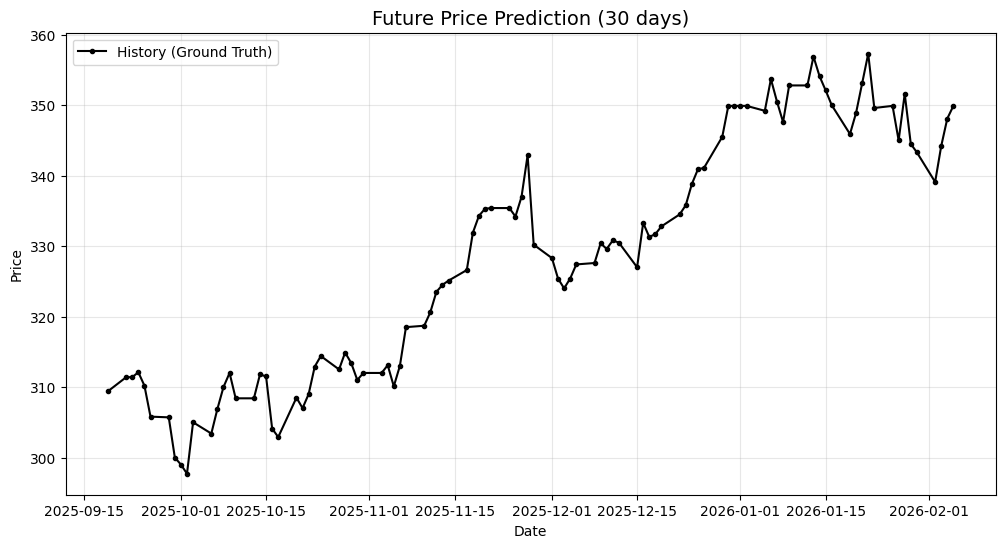

In [15]:
# Plot History + Future
plt.figure(figsize=(12, 6))

if 'df_clean' in locals() and not df_clean.empty:
    # Plot last N days of history
    history_window = 100
    history = df_clean.iloc[-history_window:]
    plt.plot(history['date'], history['close'], 'k.-', label='History (Ground Truth)', linewidth=1.5)

    for idx, (name, forecast_df) in enumerate(future_forecasts.items()):
        if not forecast_df.empty:
            # Connect last history point to first prediction
            last_inv_date = history['date'].iloc[-1]
            last_val = history['close'].iloc[-1]
            
            dates = [last_inv_date] + list(forecast_df['date'])
            values = [last_val] + list(forecast_df['pred'])
            
            # Use color cycle if possible
            if 'colors' in locals():
                 color = colors[idx % len(colors)]
            else:
                 color = None
                 
            plt.plot(dates, values, '.-', color=color, label=f'{name} Forecast')

    plt.title(f'Future Price Prediction ({FUTURE_STEPS} days)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No history data to plot.")

## Summary

| Category | Models | Training |
|----------|--------|----------|
| **Lightweight** | PatchTST, DLinear, Autoformer, iTransformer, TSTransformer | Train from scratch |
| **Fine-tuning** | TransformerFineTuner | AMP, gradient accum, warmup, early stopping |

### Key Takeaways
- **DLinear** is the simplest and fastest — excellent baseline
- **PatchTST** captures local patterns well with patch-based attention
- **Autoformer** excels with periodic/seasonal data
- **Fine-tuning** with lower LR can improve all models further